In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('dataframe.csv')

In [2]:
data = dict()
max_cases = 0

# Filtering by state code
for index, row in df.iterrows():
    state_code = row['state_code']
    if(state_code not in data):
        data[state_code] = []
    max_cases = max(max_cases, row['cases'])
    data[state_code].append([row['date'], row['cases'], row['mask_usage'], row['mobility']])

for state_code in data:
    data[state_code] = np.array(data[state_code])

max cases:  17820


In [3]:
def get_train_data_for(data, i, days_before):
    train = []
    
    for j in range(i-days_before, i):
        train.append(data[j, 1].astype('float')/max_cases) # normalization of cases
        train.append(data[j, 2].astype('float')/100) # 100 is the theoretical max (mask)
        train.append(data[j, 3].astype('float')/100) # 100 is the theoretical max (mobility)
    
    return train

def get_training_and_test_data_from_days_before(data, days_before):
    X = []
    y = []
    
    for i in range(days_before, len(data)):
        previous_days_data = get_train_data_for(data, i, days_before)
        
        X.append(np.array(previous_days_data))
        y.append(data[i, 1].astype('float')/max_cases)

    X = np.array(X)
    y = np.array(y).astype('float')
    
    return X, y

In [4]:
memo = dict()
days = [day for day in range(1, 31)]

def get_X_y_for_number_of_previous_days(prev_days, memo):
    if(prev_days in memo):
        return memo[prev_days]
    X = []
    y = []
    for state_code in data: 
        Xstate, ystate = get_training_and_test_data_from_days_before(data[state_code], prev_days)
        for el in Xstate:
            X.append(el)
        for el in ystate:
            y.append(el)
    
    X = np.array(X)
    y = np.array(y)
    memo[prev_days] = (X, y)
    return memo[prev_days]

In [5]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVR

def cross_val_with_model(model, data, days, memo, plot=True):
    mean_squared_errors = []

    for prev_days in days:
        X, y = get_X_y_for_number_of_previous_days(prev_days, memo)
        scores = cross_val_score(model, X, y, cv=10, scoring='neg_mean_squared_error')
        mean_squared_errors.append(-scores.mean())

    mean_squared_errors_np = np.array(mean_squared_errors)

    if plot:
        plt.figure()
        plt.errorbar(days, mean_squared_errors_np)
        plt.xlabel('previous days used')
        plt.ylabel('mean squared error')
        plt.title("mean squared error by previous days used")
        plt.show()

    min_val = mean_squared_errors_np.min()
    return mean_squared_errors.index(min_val)+1, min_val #index starts from 0, while days starts from 1

Linear Regression


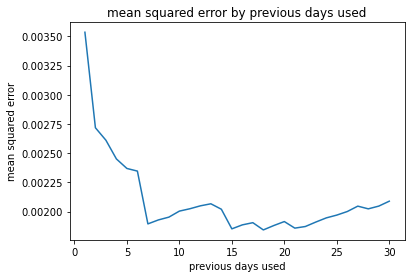

minimum mean squared error of 0.0018422638058520472 obtained with 18 previous days


In [6]:
from sklearn.linear_model import LinearRegression
print("Linear Regression")
prev_days, val = cross_val_with_model(LinearRegression(), data, days, memo)
print('minimum mean squared error of', val, 'obtained with', prev_days, 'previous days')

Lasso Regression


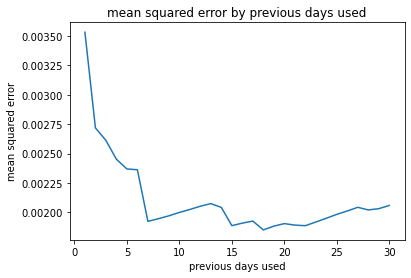

minimum mean squared error of 0.0018495952809282068 obtained with 18 previous days


In [7]:
from sklearn.linear_model import Lasso

def get_best_alpha_lasso(alphas):
    min_val = 1000
    min_alpha = 1000

    for alpha in alphas:
        current = cross_val_with_model(Lasso(alpha=alpha), data, days, memo, False)[1] # at position 1 we have the min value
        if current < min_val:
            min_val = current
            min_alpha = alpha
            
    return min_alpha, min_val

alphas = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
alpha, val = get_best_alpha_lasso(alphas)

# trying to get the best possible result in the range alpha/2 - alpha*2 where alpha was already previously preselected
alphas = np.linspace(alpha/1.2, alpha*1.2, num=10)
alpha, val = get_best_alpha_lasso(alphas)

print("Lasso Regression")
prev_days, val = cross_val_with_model(Lasso(alpha=alpha), data, days, memo)
print('minimum mean squared error of', val, 'obtained with', prev_days, 'previous days')

Ridge Regression


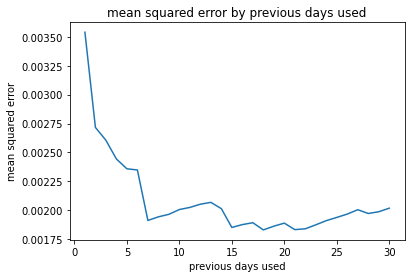

minimum mean squared error of 0.001830426839479459 obtained with 18 previous days


In [8]:
from sklearn.linear_model import Ridge

def get_best_alpha_ridge(alphas):
    min_val = 1000
    min_alpha = 1000

    for alpha in alphas:
        current = cross_val_with_model(Ridge(alpha=alpha), data, days, memo, False)[1] # at position 1 we have the min value
        if current < min_val:
            min_val = current
            min_alpha = alpha
            
    return min_alpha, min_val

alphas = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 1.5, 2]
alpha, val = get_best_alpha_ridge(alphas)

# trying to get the best possible result in the range alpha/2 - alpha*2 where alpha was already previously preselected
alphas = np.linspace(alpha/1.2, alpha*1.2, num=10)
alpha, val = get_best_alpha_ridge(alphas)

print("Ridge Regression")
prev_days, val = cross_val_with_model(Ridge(alpha=alpha), data, days, memo)
print('minimum mean squared error of', val, 'obtained with', prev_days, 'previous days')

In [9]:
# baseline median/average
from sklearn.metrics import mean_squared_error 

cases = []
average = 0

for state_code in data:
    for row in data[state_code]:
        cases_normalized = float(row[1])/max_cases #[1] is the location of cases in the row
        cases.append(cases_normalized)
        average += cases_normalized
        
cases.sort()
if len(cases)%2==0:
    median = (cases[int(len(cases)/2)-1] + cases[int(len(cases)/2)])/2
else:
    median = cases[int(len(cases)/2)]
average/=len(cases)

median_array = []
average_array = []

median = median/max_cases
for i in range(len(cases)):
    median_array.append(median)
    average_array.append(average)

print('median baseline regresson mean squared error:', mean_squared_error(cases, median_array))
print('average baseline regresson mean squared error:', mean_squared_error(cases, average_array))

median baseline regresson mean squared error: 0.018254605146834992
average baseline regresson mean squared error: 0.011366955581021338


In [10]:
# baseline day before

predictions = []
actual_values = []

for state_code in data:
    for i in range(1, len(data[state_code])):
        predictions.append(float(data[state_code][i-1][1])/max_cases) #[1] is the location of cases in the row
        actual_values.append(float(data[state_code][i][1])/max_cases) #[1] is the location of cases in the row
        
print('day before baseline regresson mean squared error:', mean_squared_error(predictions, actual_values))

day before baseline regresson mean squared error: 0.0037050126662214163
